In [14]:
working_folder = "data/021826"

In [2]:
# compute quiz scores

import json
import csv

QUIZES_PATH = f"{working_folder}/class_quizzes.json"
SUBMISSIONS_PATH = f"{working_folder}/quiz_submissions.json"
OUTPUT_CSV = f"{working_folder}/consolidated_quiz_scores.csv"

with open(QUIZES_PATH, "r", encoding="utf-8") as f:
    quizzes = json.load(f)

# quiz uuid -> { quiz_code, quiz_name, question_id -> { points, correct_option_id } }
quiz_map = {}
for q in quizzes:
    quiz_map[q["id"]] = {
        "quiz_code": q["quiz_id"],
        "quiz_name": q["title"],
        "questions": {
            qu["id"]: {"points": qu["points"], "correct_option_id": qu["correct_option_id"]}
            for qu in q["questions"]
        },
    }

with open(SUBMISSIONS_PATH, "r", encoding="utf-8") as f:
    submissions = json.load(f)

rows = []
for sub in submissions:
    info = quiz_map.get(sub["quiz_id"])
    if not info:
        continue
    total_marks = 0
    for ans in sub["answers"]:
        qu = info["questions"].get(ans["question_id"])
        if qu and ans["selected_option_id"] == qu["correct_option_id"]:
            total_marks += qu["points"]
    rows.append({
        "quiz_code": info["quiz_code"],
        "quiz_id": sub["quiz_id"],
        "quiz_name": info["quiz_name"],
        "student_id": sub["student_id"],
        "total_marks": total_marks,
    })

with open(OUTPUT_CSV, "w", newline="", encoding="utf-8") as f:
    w = csv.DictWriter(f, fieldnames=["quiz_code", "quiz_id", "quiz_name", "student_id", "total_marks"])
    w.writeheader()
    w.writerows(rows)

print(f"Wrote {len(rows)} rows to {OUTPUT_CSV}")

Wrote 7 rows to data/021826/consolidated_quiz_scores.csv


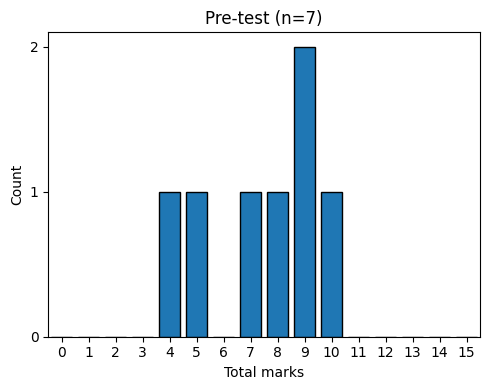

In [ ]:
# quiz scores histogram aggregated by quiz
import pandas as pd
import matplotlib.pyplot as plt

from matplotlib.ticker import MaxNLocator

df = pd.read_csv(f"{working_folder}/consolidated_quiz_scores.csv")

quizzes = df["quiz_name"].unique()
n = len(quizzes)
fig, axes = plt.subplots(1, n, figsize=(5 * max(n, 1), 4))
if n == 1:
    axes = [axes]
for ax, quiz in zip(axes, quizzes):
    sub = df[df["quiz_name"] == quiz]
    max_marks = int(sub["total_marks"].max())
    bins = [i - 0.5 for i in range(17)]  
    ax.hist(sub["total_marks"], bins=bins, rwidth=0.8, edgecolor="black")
    ax.set_xlim(-0.5, 15.5)
    ax.set_xticks(range(0, 16))
    ax.set_title(f"{quiz} (n={len(sub)})")
    ax.set_xlabel("Total marks")
    ax.set_ylabel("Count")
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
plt.tight_layout()
plt.show()

In [ ]:
import json
from pathlib import Path
from datetime import datetime

import pandas as pd

def read_json(filename):
    with open(filename, 'r') as f:
        return json.load(f)

# paths
class_groups_path = f"{working_folder}/class_groups.json"
class_assignments_path = f"{working_folder}/class_assignments.json"
assignment_submissions_path = f"{working_folder}/assignment_submissions.json"
activity_events_path = f"{working_folder}/activity_events.json"
activity_logs_path = f"{working_folder}/activity_logs.json"
content_completions_path = f"{working_folder}/content_completions.json"
class_contents_path = f"{working_folder}/class_contents.json"

class_groups = read_json(class_groups_path)
class_assignments = read_json(class_assignments_path)
assignment_submissions = read_json(assignment_submissions_path)
activity_events = read_json(activity_events_path)
activity_logs = read_json(activity_logs_path)
content_completions = read_json(content_completions_path)
class_contents = read_json(class_contents_path)

# Lookups
assignments_by_id = {a["assignment_id"]: a for a in class_assignments}
groups_by_id = {g["id"]: g["name"] for g in class_groups}

# Completion: content_completions.content_item_id = class_contents.id; class_contents (formative_assignment).ref_id = class_assignments.id
ref_id_to_assignment_id = {a["id"]: a["assignment_id"] for a in class_assignments}
content_id_to_assignment_id = {}
for cc in class_contents:
    if cc.get("type") == "formative_assignment":
        aid = ref_id_to_assignment_id.get(cc["ref_id"])
        if aid:
            content_id_to_assignment_id[cc["id"]] = aid
completion_by_student_assignment = {}
for comp in content_completions:
    aid = content_id_to_assignment_id.get(comp["content_item_id"])
    if aid:
        key = (comp["student_id"], aid)
        completion_by_student_assignment[key] = comp.get("completed_at")

print(assignments_by_id)

submissions = assignment_submissions

# Index activity_events by (submission_id, component_id, sub_component_id)
events_index = {}
for e in activity_events:
    if e.get("component_type") != "question":
        continue
    key = (e["submission_id"], e["component_id"], str(e.get("sub_component_id", "")))
    if key not in events_index:
        events_index[key] = {"start": [], "end": []}
    if e["event_type"] == "attempt_started":
        events_index[key]["start"].append(e["created_at"])
    elif e["event_type"] == "attempt_ended":
        events_index[key]["end"].append(e["created_at"])

# Index activity_logs by (submission_id, component_id, sub_component_id)
logs_index = {}
for log in activity_logs:
    if not log.get("submission_id") or log.get("component_type") != "question":
        continue
    key = (log["submission_id"], log["component_id"], str(log.get("sub_component_id", "")))
    if key not in logs_index:
        logs_index[key] = []
    logs_index[key].append(log)

rows = []

no_assignment_id = [sub for sub in submissions if not sub.get("assignment_id")]
print(f"Submissions without assignment_id: {len(no_assignment_id)}")
for sub in no_assignment_id:
    print(sub)

for sub in submissions:
    assignment_id = sub.get("assignment_id")
    if not assignment_id:
        continue
    assignment = assignments_by_id.get(assignment_id)
    if not assignment:
        continue
    group_name = groups_by_id.get(assignment["class_group_id"], "")
    student_id = sub["student_id"]
    preferred_language = sub.get("preferred_language", "")
    submission_mode = sub.get("submission_mode", "")
    submission_id = sub["submission_id"]

    evaluations = sub.get("evaluations") or {}
    if not evaluations:
        # One row per question from assignment definition if no evaluations
        for q in assignment.get("questions", []):
            qnum = str(q["order"])
            max_pts = q.get("total_points", 0)
            key = (submission_id, assignment_id, qnum)
            event_start = event_end = None
            if key in events_index:
                ev = events_index[key]
                event_start = min(ev["start"]) if ev["start"] else None
                event_end = max(ev["end"]) if ev["end"] else None
            log_list = logs_index.get(key, [])
            total_time_ms = sum(l["total_time_ms"] for l in log_list)
            created_ats = [l["created_at"] for l in log_list]
            time_span_ms = None
            total_time_ms_in_event_window = None
            if event_start and event_end:
                try:
                    t0 = datetime.fromisoformat(event_start.replace("Z", "+00:00"))
                    t1 = datetime.fromisoformat(event_end.replace("Z", "+00:00"))
                    time_span_ms = int((t1 - t0).total_seconds() * 1000)
                    logs_in_window = [l for l in log_list if t0 <= datetime.fromisoformat(l["created_at"].replace("Z", "+00:00")) <= t1]
                    total_time_ms_in_event_window = sum(l["total_time_ms"] for l in logs_in_window) if logs_in_window else None
                except Exception:
                    pass
            completion_key = (student_id, assignment_id)
            completed = completion_key in completion_by_student_assignment
            completed_at = completion_by_student_assignment.get(completion_key)
            row = {
                "student_id": student_id,
                "group_name": group_name,
                "assignment_id": assignment_id,
                "assignment_name": assignment.get("title", ""),
                "preferred_language": preferred_language,
                "submission_mode": submission_mode,
                "question_number": qnum,
                "max_possible_score": max_pts,
                "number_of_attempts": 0,
                "scores":"",
                "highest_score": None,
                "completed": completed,
                "completed_at": completed_at,
                "event_start_time": event_start,
                "event_end_time": event_end,
                "number_of_event_logs_available": len(log_list),
                "created_at_logs": "|".join(created_ats) if created_ats else "",
                "total_time_ms": total_time_ms if log_list else None,
                "total_time_ms_in_event_window": total_time_ms_in_event_window,
                "time_span_ms": time_span_ms,
            }
            rows.append(row)
        continue

    for qnum, ev_data in evaluations.items():
        attempts = ev_data.get("attempts") or []
        scores = [a["score"] for a in attempts]
        max_score = attempts[0]["max_score"] if attempts else None
        if max_score is None and assignment.get("questions"):
            for q in assignment["questions"]:
                if str(q["order"]) == qnum:
                    max_score = q.get("total_points")
                    break
        highest = max(scores) if scores else None

        key = (submission_id, assignment_id, qnum)
        event_start = event_end = None
        if key in events_index:
            ev = events_index[key]
            event_start = min(ev["start"]) if ev["start"] else None
            event_end = max(ev["end"]) if ev["end"] else None
        log_list = logs_index.get(key, [])
        total_time_ms = sum(l["total_time_ms"] for l in log_list)
        created_ats = [l["created_at"] for l in log_list]
        time_span_ms = None
        total_time_ms_in_event_window = None
        if event_start and event_end:
            try:
                t0 = datetime.fromisoformat(event_start.replace("Z", "+00:00"))
                t1 = datetime.fromisoformat(event_end.replace("Z", "+00:00"))
                time_span_ms = int((t1 - t0).total_seconds() * 1000)
                logs_in_window = [l for l in log_list if t0 <= datetime.fromisoformat(l["created_at"].replace("Z", "+00:00")) <= t1]
                total_time_ms_in_event_window = sum(l["total_time_ms"] for l in logs_in_window) if logs_in_window else None
            except Exception:
                pass

        completion_key = (student_id, assignment_id)
        completed = completion_key in completion_by_student_assignment
        completed_at = completion_by_student_assignment.get(completion_key)
        row = {
            "student_id": student_id,
            "group_name": group_name,
            "assignment_id": assignment_id,
            "assignment_name": assignment.get("title", ""),
            "preferred_language": preferred_language,
            "submission_mode": submission_mode,
            "question_number": qnum,
            "max_possible_score": max_score,
            "number_of_attempts": len(attempts),
            "scores": ",".join(str(s) for s in scores),
            "highest_score": highest,
            "completed": completed,
            "completed_at": completed_at,
            "event_start_time": event_start,
            "event_end_time": event_end,
            "number_of_event_logs_available": len(log_list),
            "created_at_logs": "|".join(created_ats) if created_ats else "",
            "total_time_ms": total_time_ms if log_list else None,
            "total_time_ms_in_event_window": total_time_ms_in_event_window,
            "time_span_ms": time_span_ms,
        }
        rows.append(row)

df = pd.DataFrame(rows)
out_path = f"{working_folder}/assignment_submissions_analysis.csv"
df.to_csv(out_path, index=False)
print(f"Wrote {len(df)} rows to {out_path}")

C:\Users\Deepak\AppData\Local\Temp\ipykernel_15892\965792239.py:18: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data_by_group, labels=groups, patch_artist=True)


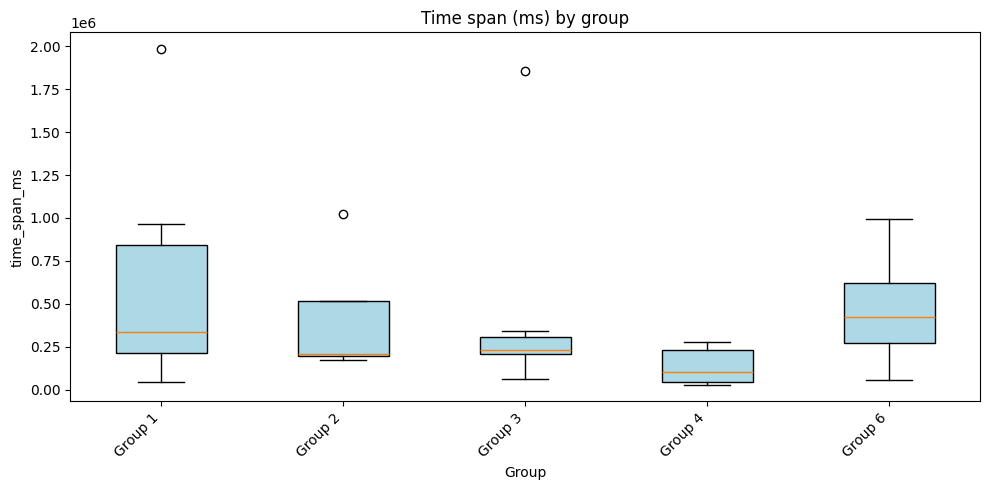

In [27]:
# Chart: time_span_ms comparison between groups
import pandas as pd
import matplotlib.pyplot as plt

# Use df from previous cell, or load CSV
try:
    plot_df = df.copy()
except NameError:
    plot_df = pd.read_csv(f"{working_folder}/assignment_submissions_analysis.csv")

plot_df = plot_df.dropna(subset=["time_span_ms"])
if plot_df.empty:
    print("No time_span_ms data to plot.")
else:
    fig, ax = plt.subplots(figsize=(10, 5))
    groups = sorted(plot_df["group_name"].unique())
    data_by_group = [plot_df.loc[plot_df["group_name"] == g, "time_span_ms"].values for g in groups]
    bp = ax.boxplot(data_by_group, labels=groups, patch_artist=True)
    for patch in bp["boxes"]:
        patch.set_facecolor("lightblue")
    ax.set_ylabel("time_span_ms")
    ax.set_xlabel("Group")
    ax.set_title("Time span (ms) by group")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()